# Bike Crashes Data Mining / ML Analysis

## Leading Question: What variables lead to the most dangerous bike crashes in Chicago?

## Process: Build classification model to find most dangerous bike crashes and examine top feature importances


In [189]:
# imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import folium
import geopandas as gpd
from folium.features import GeoJson
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    StratifiedKFold,
    cross_val_predict,
)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn import set_config

# Load Data

### (Get around limits of API with loop to get data back to 2018)

#### limit of 1000 rows per call so call ev month back to 2018 from 2023


In [91]:
# Define the start and end dates of the desired time range
start_date = pd.to_datetime("2016-01-01")  # make this go back to 2016 to get more data
end_date = pd.to_datetime("2023-05-30")

# Define the interval duration (e.g., one month)
interval = pd.DateOffset(months=1)

# Create an empty list to store the data
data = []

# Iterate over each interval within the time range
current_date = start_date
while current_date <= end_date:
    # Construct the URL for the current interval
    url = "https://data.cityofchicago.org/resource/85ca-t3if.csv"
    # Add the date filter to the URL
    query = f"$where=crash_date between '{current_date.date()}' and '{(current_date + interval).date()}'"
    # Add additional filters as needed
    query += " AND first_crash_type='PEDALCYCLIST'"
    # Encode the URL
    encoded_url = urllib.parse.quote(f"{url}?{query}", safe=":/?=&")

    # Retrieve the data for the current date interval
    df = pd.read_csv(encoded_url)

    # Append the data to the list
    data.append(df)

    # Move to the next interval
    current_date += interval

# Combine the data from all intervals into a single DataFrame
bike_crashes = pd.concat(data, ignore_index=True)

bike_crashes.shape

(10482, 49)

# Explore Bike Crash Data


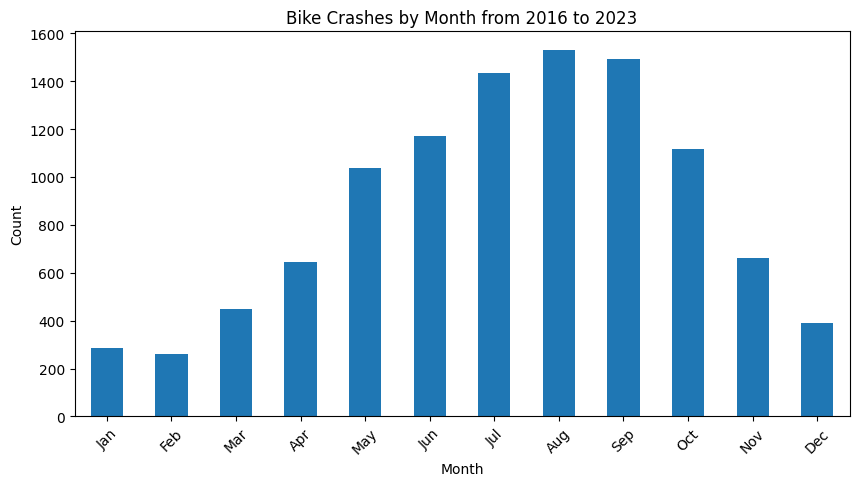

In [4]:
# Bike crashes by month
bike_crashes["crash_month"] = pd.DatetimeIndex(bike_crashes["crash_date"]).month
crashes_by_month = bike_crashes["crash_month"].value_counts().sort_index()

crashes_by_month.plot(kind="bar", figsize=(10, 5))

plt.xlabel("Month")
plt.xticks(
    range(12),
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    rotation=45,
)

plt.ylabel("Count")
plt.title("Bike Crashes by Month from 2016 to 2023")
plt.show()

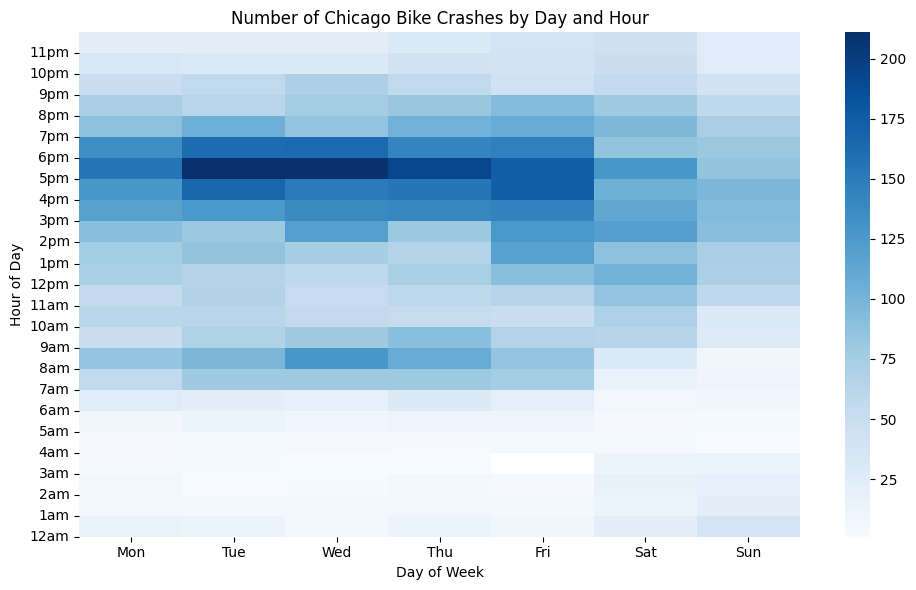

In [5]:
# crashes by day of week and hour

bike_crashes["crash_dayofweek"] = pd.DatetimeIndex(bike_crashes["crash_date"]).dayofweek
bike_crashes["crash_hour"] = pd.DatetimeIndex(bike_crashes["crash_date"]).hour
crashes_by_dayhour = bike_crashes.pivot_table(
    index="crash_hour", columns="crash_dayofweek", aggfunc="size"
)
plt.figure(figsize=(10, 6))

# create heatmap
sns.heatmap(crashes_by_dayhour, cmap="Blues")

# set x-axis tick labels to day of week
plt.gca().set_xticks([i + 0.5 for i in range(7)])
plt.gca().set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

# set y-axis labele to 12 hour time
plt.yticks(
    range(24),
    [
        "12am",
        "1am",
        "2am",
        "3am",
        "4am",
        "5am",
        "6am",
        "7am",
        "8am",
        "9am",
        "10am",
        "11am",
        "12pm",
        "1pm",
        "2pm",
        "3pm",
        "4pm",
        "5pm",
        "6pm",
        "7pm",
        "8pm",
        "9pm",
        "10pm",
        "11pm",
    ],
    rotation=0,
)

# add axis labels and title
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.title("Number of Chicago Bike Crashes by Day and Hour")

# flip y axis
plt.gca().invert_yaxis()

# make plot pretty
plt.tight_layout()
# display plot
plt.show()

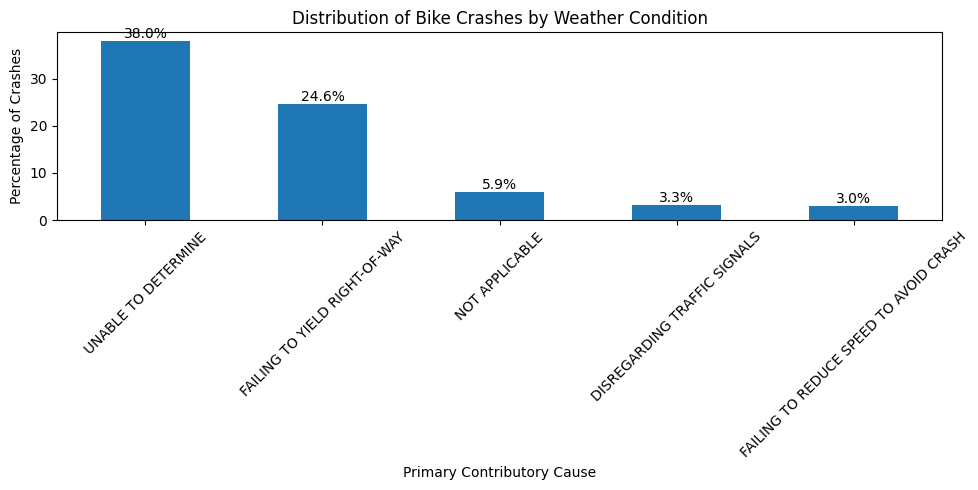

In [6]:
# bike crash reasons
plt.figure(figsize=(10, 5))
total_crashes = len(bike_crashes)
reason_counts = (
    bike_crashes["prim_contributory_cause"].value_counts() / total_crashes * 100
)
# only plot top 5 reasons
reason_counts[:5].plot(kind="bar")
# reason_counts.plot(kind="bar")

# Set axis labels and title
plt.xlabel("Primary Contributory Cause")
plt.xticks(rotation=45)
plt.ylabel("Percentage of Crashes")
plt.title("Distribution of Bike Crashes by Weather Condition")


# Add percentage labels to the bars
for i, count in enumerate(reason_counts[:5]):
    plt.text(i, count, f"{count:.1f}%", ha="center", va="bottom")

# Make plot pretty
plt.tight_layout()

# Display plot
plt.show()

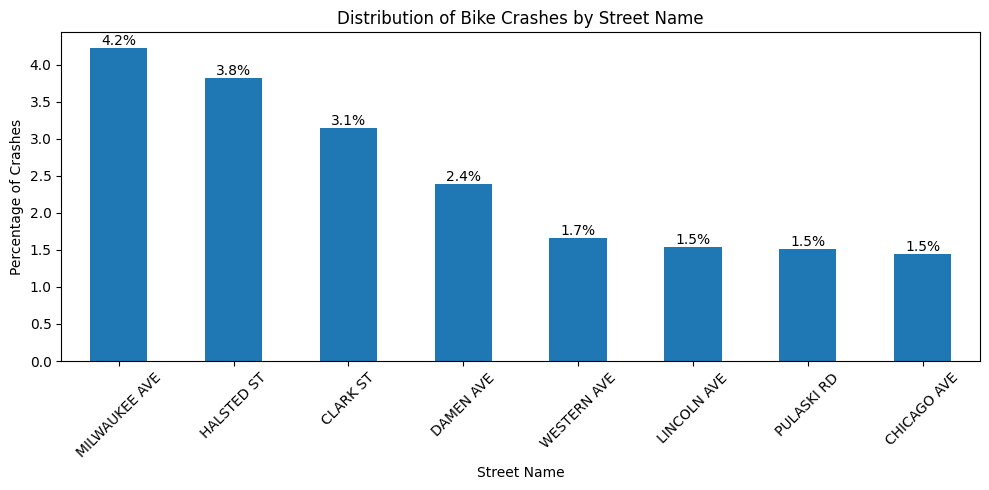

In [7]:
# most dangerous streets
plt.figure(figsize=(10, 5))
total_crashes = len(bike_crashes)
reason_counts = bike_crashes["street_name"].value_counts() / total_crashes * 100
# only plot top 8
reason_counts[:8].plot(kind="bar")

# Set axis labels and title
plt.xlabel("Street Name")
plt.xticks(rotation=45)
plt.ylabel("Percentage of Crashes")
plt.title("Distribution of Bike Crashes by Street Name")

# Add percentage labels to the bars
for i, count in enumerate(reason_counts[:8]):
    plt.text(i, count, f"{count:.1f}%", ha="center", va="bottom")

# Make plot pretty
plt.tight_layout()

# Display plot
plt.show()

# EDA Takeaways

- Most crashes occur July/Aug which makes sense since more bikers are out. I was surprised the weather didn't dramatically increase winter crashes.
- I was surprised that weekly crashes happen most on Tuesday-Thursday. It makes sense that it happens around commuter times but those days specifically I'm guessing have to do with hybrid work people biking to the loop Tue and Thur but would need more data to confirm.
- Why are people biking on Western??
- 'Failing to Yield to Right of Way' means blowing stop signs so that makes sense as a leading cause of crashing
- next step is to explore the kinds of bikers (and drivers) that get in these accidents


In [8]:
# Load the street data as a GeoDataFrame
# got from this repo: https://github.com/blackmad/neighborhoods/blob/master/chicago.geojson
streets_gdf = gpd.read_file(
    "/Users/benbavonese1/Desktop/coding/bike_crashes/Transportation.geojson"
)

In [ ]:
# Create a map centered around Chicago
chicago_map = folium.Map(
    location=[41.8781, -87.6298], zoom_start=11, tiles="cartodbdark_matter"
)
# cartodbpositron is light and pretty good, cartodbdark_matter is dark and looks a bit more dramatic

# Calculate the number of crashes on each street segment
bike_crashes["crash_date"] = pd.to_datetime(bike_crashes["crash_date"])
bike_crashes_may = bike_crashes[bike_crashes["crash_date"].dt.month == 5]

street_crash_counts = (
    bike_crashes.groupby("street_name").size().reset_index(name="crash_count")
)

# remove street endings from street_crash_counts df to match streets_gdf
street_endings = [
    "AVE",
    "ST",
    "RD",
    "DR",
    "BLVD",
    "PKWY",
    "N",
    "END",
    "S",
    "E",
    "W",
    "HW",
    "CT",
]


def remove_street_endings(street):
    for ending in street_endings:
        pattern = rf"\b{ending}\b"
        street = re.sub(pattern, "", street)
    return street.strip()


street_crash_counts["street_name"] = street_crash_counts["street_name"].apply(
    remove_street_endings
)

# rename column
street_crash_counts.rename(columns={"street_name": "STREET_NAM"}, inplace=True)

# Merge the street data with the crash counts based on the street segment name
streets_gdf_merged = streets_gdf.merge(
    street_crash_counts[["STREET_NAM", "crash_count"]], on="STREET_NAM", how="left"
)


# Set the style function for the choropleth layer
def style_function(feature):
    count = feature["properties"]["crash_count"]
    if count is None:
        return {"weight": 0.0, "fillOpacity": 0.0}
    else:
        # Define the minimum and maximum crash count values to determine the gradient range
        min_count = 0  # minimum crash count
        max_count = 300  # maximum crash count (adjust as needed) change to 10 and then im calling it a day

        # Calculate the color based on the crash count using a linear interpolation
        normalized_count = (count - min_count) / (max_count - min_count)
        fill_opacity = normalized_count
        # print(fill_opacity)
        return {
            "color": "red",
            "weight": normalized_count,
            "fillOpacity": 0.5,  # make this proportional to the number of crashes
        }


# Load the latitude and longitude data for lethal bike accidents from another DataFrame
lethal_accidents_df = bike_crashes[bike_crashes["injuries_fatal"] == 1][
    ["latitude", "longitude"]
]

# Iterate over the rows of lethal_accidents_df and add markers for each lethal accident location
for _, row in lethal_accidents_df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        icon=folium.Icon(icon="times", prefix="fa", color="red"),
    ).add_to(chicago_map)

# Create the choropleth layer
geojson = GeoJson(streets_gdf_merged, style_function=style_function)
chicago_map.add_child(geojson)

# Display the map
chicago_map

# Data Mining / Modeling


In [149]:
# clean data for model

num_cols = [
    "posted_speed_limit",
    "latitude",
    "longitude",
]

cat_cols = [
    "crash_hour",
    "crash_day_of_week",
    "crash_month",
    "lighting_condition",
    "weather_condition",
    "road_defect",
    "traffic_control_device",
    "trafficway_type",
    "roadway_surface_cond",
    "street_name",
    "street_direction",
]

target = ["target"]

bike_crashes_full = bike_crashes.copy()
bike_crashes["target"] = np.where(
    (bike_crashes["most_severe_injury"] == "INCAPACITATING INJURY")
    | (bike_crashes["most_severe_injury"] == "FATAL INJURY"),
    1,
    0,
)
bike_crashes_full["crash_date"] = bike_crashes_full["crash_date"].astype(str)
bike_crashes_full = bike_crashes_full[num_cols + cat_cols + target]


# split data in train and validation
train, validation = train_test_split(
    bike_crashes_full,
    test_size=0.5,
    stratify=bike_crashes_full["target"],
    random_state=42,
)

X_train = train.drop("target", axis=1)
y_train = train["target"].copy()

X_test = validation.drop("target", axis=1)
y_test = validation["target"].copy()

# data is heavily imbalanced
bike_crashes_full["target"].value_counts()

target
0    9476
1    1006
Name: count, dtype: int64

In [185]:
set_config(transform_output="pandas")  # so we can get the column names

# Define the preprocessing steps for numerical and categorical columns
num_preprocessor = make_pipeline(KNNImputer(n_neighbors=10), StandardScaler())

cat_preprocessor = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
)

pca = PCA(n_components=0.99)

# Create the column transformer to apply different preprocessing steps to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_preprocessor, num_cols),
        ("cat", make_pipeline(cat_preprocessor, pca), cat_cols),
    ]
)

X_combined = pd.concat([X_train, X_test], axis=0)

# to get all street names in train and test
X_combined_transformed = preprocessor.fit_transform(X_combined)
X_train_transformed = X_combined_transformed[: X_train.shape[0]]
X_test_transformed = X_combined_transformed[X_train.shape[0] :]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4738
           1       0.07      0.02      0.03       503

    accuracy                           0.88      5241
   macro avg       0.49      0.50      0.48      5241
weighted avg       0.82      0.88      0.85      5241



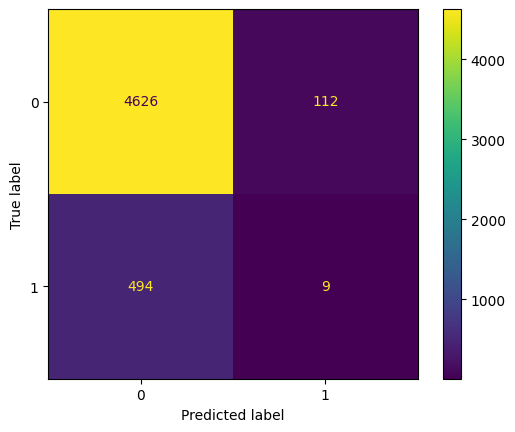

In [186]:
forest_clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    random_state=42,  # Random seed for reproducibility
    max_depth=5,  # Maximum depth of each tree
    min_samples_leaf=1,  # Minimum number of samples required at each leaf node
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    max_features="sqrt",  # Number of features to consider when looking for the best split
    bootstrap=True,  # Whether bootstrap samples are used when building trees
    class_weight="balanced",  # Weight classes inversely proportional to their frequency
)

forest_clf.fit(X_train_transformed, y_train)

y_pred = cross_val_predict(forest_clf, X_test_transformed, y_test, cv=5)

# Evaluate the model on the testing data
print(classification_report(y_test, y_pred, zero_division=1))


# plot confusion matrix of results
cm = confusion_matrix(y_test, y_pred, labels=forest_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_clf.classes_)
disp.plot()

plt.show()

In [ ]:
# ROC Curve

# Get predicted probabilities for positive class
y_pred_proba = forest_clf.predict_proba(X_train_transformed)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# do dummy testing as benchmark


dummy = DummyClassifier()

dummy.fit(X_train_transformed, y_train)

dummy_pred = dummy.predict(X_test_transformed)

print("dummy accuracty: ", accuracy_score(y_test, dummy_pred))

y_test.shape
y_pred.shape

In [ ]:
# Learning Curve graph

# Define the number of folds
n_folds = 5

# Create the stratified k-fold object
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Calculate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=forest_clf,
    X=X_train_transformed,
    y=y_train,
    cv=stratified_kfold,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy",
    n_jobs=-1,
)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.3)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

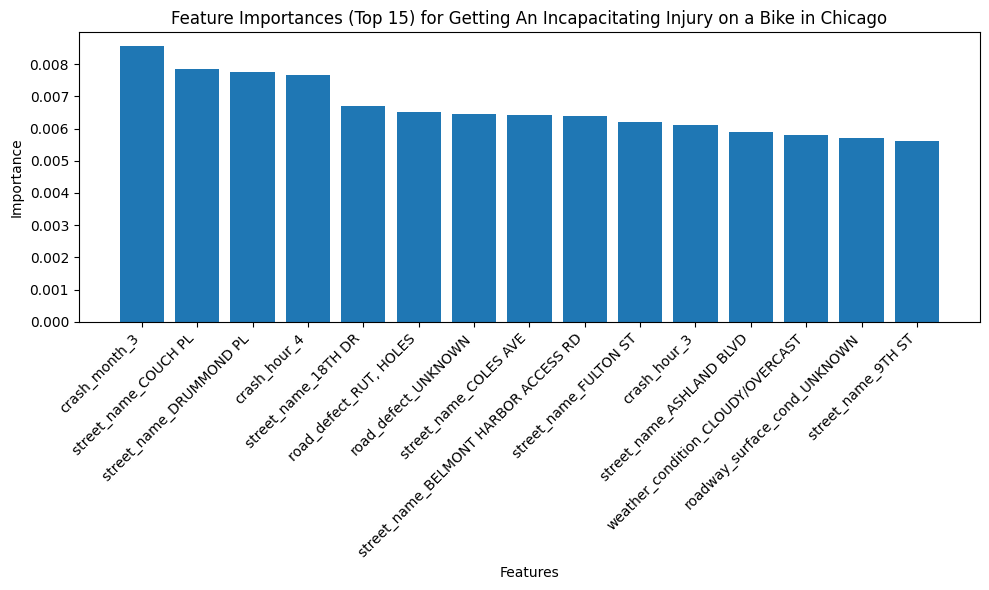

In [190]:
# Best model feature importances

# Get the feature importances
importances = forest_clf.feature_importances_

# Get the names of the features
feature_names = (
    preprocessor.transformers_[1][1]["pipeline"]
    .steps[-1][1]
    .get_feature_names_out(cat_cols)
)

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances[:15])), sorted_importances[:15])
plt.xticks(
    range(len(sorted_importances[:15])),
    sorted_feature_names[:15],
    rotation=45,
    ha="right",
)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title(
    "Feature Importances (Top 15) for Getting An Incapacitating Injury on a Bike in Chicago"
)
plt.tight_layout()
plt.show()

## Final Analysis + Further Questions

### With the best model I found:

- Most dangerous crashes depended on:
  1. Date being March
  2. Certain streets (Couch, Drummond, 18th)
  3. Time of day being early in the morning (3/4 am)

### Further Questions

- Why do bike crashes tend to be more dangerous in March compared to other months?
- What are the characteristics of the streets (Couch, Drummond, 18th) that make them more prone to dangerous bike crashes?
- Are there any specific factors or conditions during the early morning hours (3/4 am) that contribute to the severity of bike crashes?
- Are there any additional variables or features that could potentially be included in the analysis to further improve the model's predictive performance?
- Have you considered exploring the relationship between weather conditions and bike crashes to understand how different weather patterns affect the severity of crashes?
- Are there any patterns or trends in the data that suggest specific interventions or safety measures that could be implemented to reduce the occurrence of dangerous bike crashes in Chicago?
- Could there be any underlying factors or demographic characteristics associated with the identified streets or time periods that contribute to the higher risk of dangerous bike crashes?
- Can I find data to explore any correlations between the identified variables (e.g., date, streets, time) and other available information in the dataset, such as traffic volume, road conditions, or visibility, to gain further insights?
